In [1]:
# Imports of used libraries throughout the notebook
import numpy as np
import h5py
import math
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pickle
import os
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# Blood Pressure/ Sleep Stage Modeling experiments for predicting cardiovascular risk
The goal of this project is simple. If given the nighttime blood pressure and sleep stage data of a specific person (along with other relevant health factors) can we categorize a person's cardiovascular risk. We will be working with two different datasets for this model, the MESA dataset and the MIMIC-III Dataset. The MESA dataset contains ppg data + ECG + sleep stage readings while the MIMIC-III dataset contains, BP data + ECG data + PPG Data. Each dataset only has one element of what we need however ppg can be used to estimate Blood Pressure and ECG can be used to estimate sleep stage data. We will be exploring methods for generating this data using a Sleep Stage Estimation model and a PPG2ABP model. We will then use the data from both datasets to train and test a Cardiovascular Risk Assessment model and analyze the results.

This notebook contains our research and analysis of the PPG2ABP model and different algorithms we have developed to improve the model's predictions and additionally, algorithms that can help with usage of the model in applied clinical settings.


## Using PPG data for continuous blood pressure estimations
### Concerns regarding racial bias and our findings
 It is important to note that various projects and research papers have concluded that ppg signals have more interference when recorded on people with darker skin tones due to how the technology works, in turn this can result in less accurate results when getting blood pressure estimations on people with darker skin. The model used to make blood pressure estimations from ppg signals is from this paper: https://arxiv.org/abs/2005.01669. The model was trained using the MIMIC-III dataset which contains both continuous cuff blood pressure readings and ppg data which allows for training a model that is able to make these predictions. The github repo associated with the model contains testing outputs and validations from its own testing subset of mimic, however for us to get a comprehensive understanding of whether the model is racially biased, we must create our own testing subset of MIMIC-III that contains a somewhat even split of test subjects across different races.

**You can pre-process your own dataset by running the data_pipeline.py script located in the MIMIC-III Database Management folder or you can download it from this google drive link [link here] and place it in a folder titled "processed_data" within the MIMIC-III Database Management folder to reproduce results**

In [2]:
# import of relevant libraries
import helper_functions_bp_model as hf

In [3]:
# get list of patient IDs and additionally sort the patient IDs into different dictionary lists based on the race of the patient
path = 'MIMIC-III-Database-Management/processed_data'
file_list = os.listdir(path)

patient_race_sorted_dict = {
    "WHITE" : [],
    "BLACK" : [],
    "HISPANIC" : [],
    "ASIAN" : [],
    "OTHER" : []
}
patient_list_complete = []

for file in file_list:
    if file.startswith('p') is True:
        patient_list_complete.append(file)
        race = hf.get_patient_records(file)["ETHNICITY"]
        match race:
            case _ if "WHITE" in race:
                patient_race_sorted_dict["WHITE"].append(file)
                patient_race_sorted_dict["WHITE"].sort()
            case _ if "BLACK" in race:
                patient_race_sorted_dict["BLACK"].append(file)
                patient_race_sorted_dict["BLACK"].sort()
            case _ if "HISPANIC" in race:
                patient_race_sorted_dict["HISPANIC"].append(file)
                patient_race_sorted_dict["HISPANIC"].sort()
            case _ if "ASIAN" in race:
                patient_race_sorted_dict["ASIAN"].append(file)
                patient_race_sorted_dict["ASIAN"].sort()
            case _:
                patient_race_sorted_dict["OTHER"].append(file)
                patient_race_sorted_dict["OTHER"].sort()
    else:
        file_list.remove(file)

We are going to run our tests on ~500 patients from the MIMIC database. This model was trained by mixing a bunch of different patient episodes together (10 second bp and ppg readings) and training to find the correlation between those episodes. The model wasn't trained on a patient to patient basis so it had no way of knowing the different races that different readings from MIMIC were coming from. This is why we are using our own subset of MIMIC data so we can test across different demographics and see if there is a racial bias that exists in our model.

Side note: for visualization purposes, yes I am "cherrypicking" ppg segments to look at (i really am just picking the first one I find that works), unfortunately I havent yet figured out a good filter function to filter out the good data from the bad (good = the ppg or blood pressure signal present makes sense)

Text(0.5, 1.0, 'Hispanic Patient PPG (Patient#: p006158)')

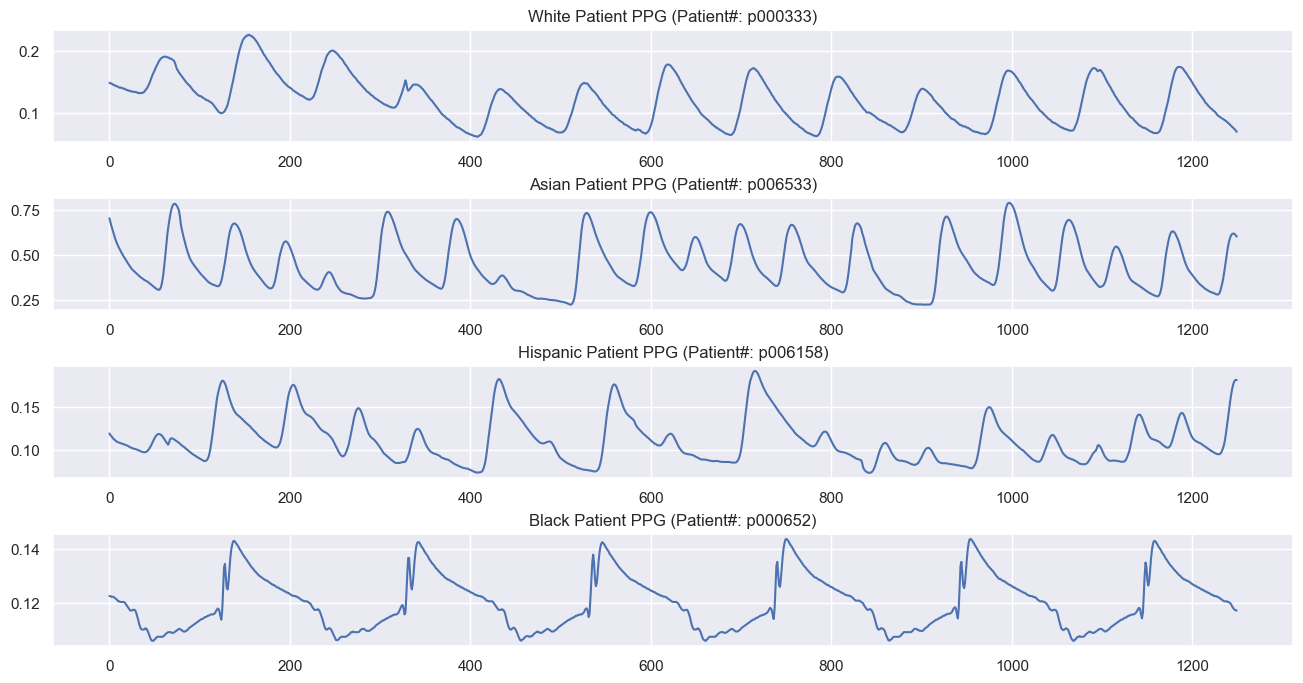

In [4]:
selected_white_patient = 0
selected_black_patient = 0
selected_hispanic_patient = 4
selected_asian_patient = 4

fig, (white, asian, hispanic, black) = plt.subplots(4, 1, figsize=(16, 8), gridspec_kw={'hspace': 0.5})

white_norm_ppg, white_actual_abp, white_ecg = hf.get_patient_episode_data(patient_race_sorted_dict['WHITE'][selected_white_patient], 1)
white.plot(white_norm_ppg)
white.set_title(f"White Patient PPG (Patient#: {patient_race_sorted_dict['WHITE'][selected_white_patient]})")

black_norm_ppg, black_actual_abp, black_ecg = hf.get_patient_episode_data(patient_race_sorted_dict['BLACK'][selected_black_patient], 1)
black.plot(black_norm_ppg)
black.set_title(f"Black Patient PPG (Patient#: {patient_race_sorted_dict['BLACK'][selected_black_patient]})")

asian_norm_ppg, asian_acutal_abp, asian_ecg = hf.get_patient_episode_data(patient_race_sorted_dict['ASIAN'][selected_asian_patient], 1)
asian.plot(asian_norm_ppg)
asian.set_title(f"Asian Patient PPG (Patient#: {patient_race_sorted_dict['ASIAN'][selected_asian_patient]})")

hispanic_norm_ppg, hispanic_actual_abp, hispanic_ecg = hf.get_patient_episode_data(patient_race_sorted_dict['HISPANIC'][selected_hispanic_patient], 1)
hispanic.plot(hispanic_norm_ppg)
hispanic.set_title(f"Hispanic Patient PPG (Patient#: {patient_race_sorted_dict['HISPANIC'][selected_hispanic_patient]})")

Shown above are the normalized PPG signals from different patients. The model requires all ppg signals are normalized using min-max normalization before it can be used for prediction. Below we run these normalized ppg signals through the model to see how the model performs.

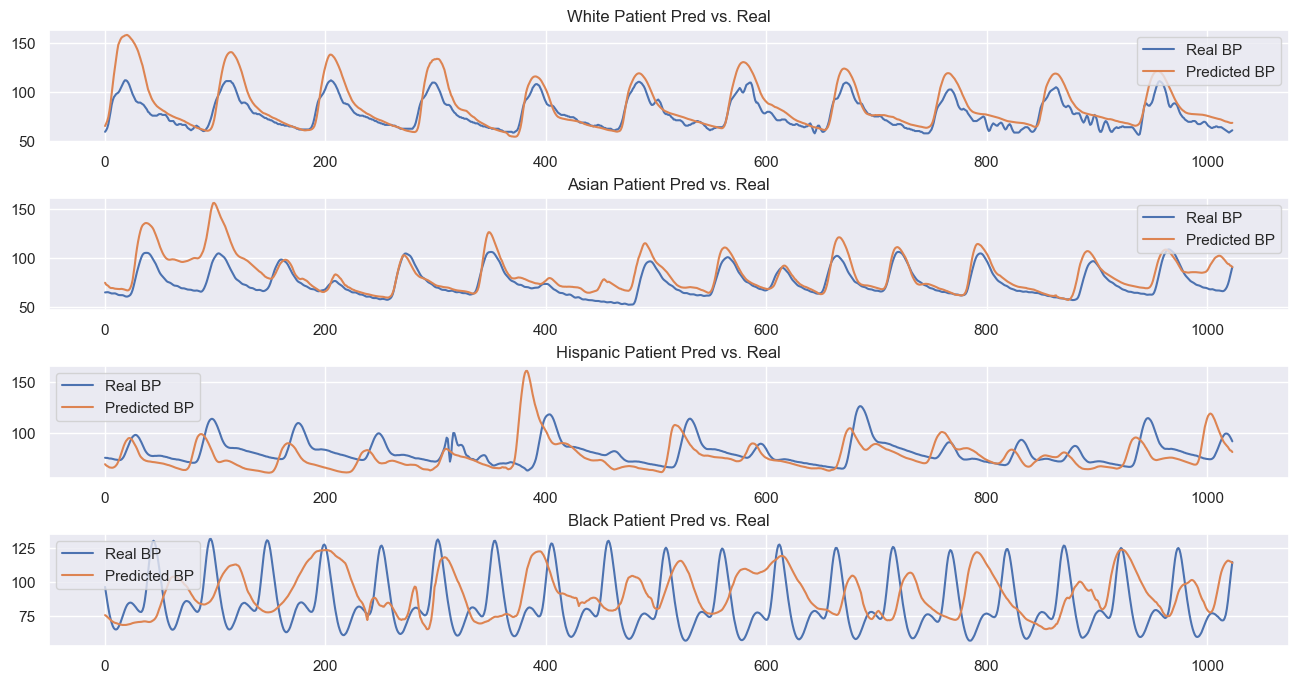

In [5]:
# patient predictions
white_pred_bp = hf.predict_bp_from_ppg(white_norm_ppg)
blk_pred_bp = hf.predict_bp_from_ppg(black_norm_ppg)
asn_pred_bp = hf.predict_bp_from_ppg(asian_norm_ppg)
his_pred_bp = hf.predict_bp_from_ppg(hispanic_norm_ppg)

# plot the results
fig, (white, asian, hispanic, black) = plt.subplots(4, 1, figsize=(16, 8), gridspec_kw={'hspace': 0.5})
white.plot(hf.trim_waveform(white_actual_abp), label="Real BP")
white.plot(white_pred_bp, label="Predicted BP")
white.set_title("White Patient Pred vs. Real")
white.legend()

asian.plot(hf.trim_waveform(asian_acutal_abp), label="Real BP")
asian.plot(asn_pred_bp, label="Predicted BP")
asian.set_title("Asian Patient Pred vs. Real")
asian.legend()

hispanic.plot(hf.trim_waveform(hispanic_actual_abp), label="Real BP")
hispanic.plot(his_pred_bp, label="Predicted BP")
hispanic.set_title("Hispanic Patient Pred vs. Real")
hispanic.legend()

black.plot(hf.trim_waveform(black_actual_abp), label="Real BP")
black.plot(blk_pred_bp, label="Predicted BP")
black.set_title("Black Patient Pred vs. Real")
black.legend()

Visually we can see that for the majority of the patients, the model does a good job predicting the shape of the blood pressure waveform and seems to do a good job of predicting the blood pressure values for different patients. However, this doesn't give us a numerical metric for being able to "grade" how the model is performing so we will be using the metrics and grading system suggested by the British Hypertension Society to grade the model's performance.

In [6]:
# import relevant libraries
import evaluation_functions as ef

In [7]:
print("White Patient Evaluation")
ef.eval_bhs_standard(white_actual_abp, white_pred_bp, white_ecg)
print("Asian Patient Evaluation")
ef.eval_bhs_standard(asian_acutal_abp, asn_pred_bp, asian_ecg)
print("Hispanic Patient Evaluation")
ef.eval_bhs_standard(hispanic_actual_abp, his_pred_bp, hispanic_ecg)
print("Black Patient Evaluation")
ef.eval_bhs_standard(black_actual_abp, blk_pred_bp, black_ecg)

White Patient Evaluation
|     |   ≤5 mmHg |   ≤10 mmHg |   ≤15 mmHg | BHS Grade   |
|:----|----------:|-----------:|-----------:|:------------|
| SBP |    0      |    18.1818 |    45.4545 | D           |
| DBP |   63.6364 |    90.9091 |   100      | A           |
| MBP |   18.1818 |    72.7273 |    90.9091 | D           |
Asian Patient Evaluation
|     |   ≤5 mmHg |   ≤10 mmHg |   ≤15 mmHg | BHS Grade   |
|:----|----------:|-----------:|-----------:|:------------|
| SBP |   11.1111 |    22.2222 |    55.5556 | D           |
| DBP |   55.5556 |    77.7778 |   100      | B           |
| MBP |   22.2222 |    77.7778 |    77.7778 | D           |
Hispanic Patient Evaluation
|     |   ≤5 mmHg |   ≤10 mmHg |   ≤15 mmHg | BHS Grade   |
|:----|----------:|-----------:|-----------:|:------------|
| SBP |    0      |    33.3333 |    44.4444 | D           |
| DBP |   66.6667 |    77.7778 |    88.8889 | C           |
| MBP |   22.2222 |    66.6667 |    88.8889 | D           |
Black Patient Evaluati

As we can see, the model does not perform well for any of these patients. However, this could be a fluke and these are just bad patient selections (especially for the selected black patient). Now lets run evaluation on 1 episode segments for all patients within our database and see how the model performs on a race by race basis.

In [8]:
import validation_pipeline as vp

|     |   ≤5 mmHg |   ≤10 mmHg |   ≤15 mmHg | BHS Grade   |
|:----|----------:|-----------:|-----------:|:------------|
| SBP |   17.252  |    36.379  |    49.7272 | D           |
| DBP |   12.5    |    39.6875 |    57.178  | D           |
| MBP |   21.6919 |    44.2172 |    57.2876 | D           |


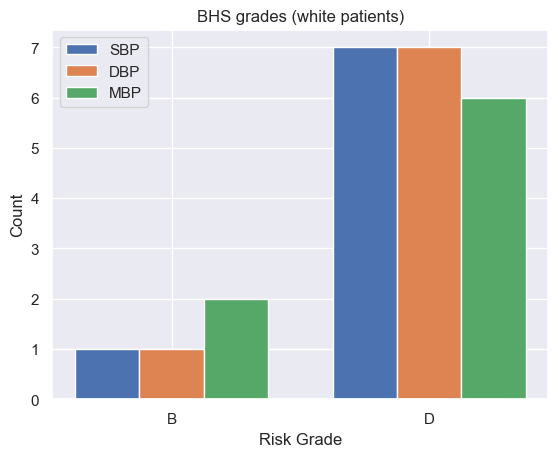

|     |   ≤5 mmHg |   ≤10 mmHg |   ≤15 mmHg | BHS Grade   |
|:----|----------:|-----------:|-----------:|:------------|
| SBP |   28.9352 |    46.2731 |    52.8472 | D           |
| DBP |   19.8148 |    34.537  |    55.4861 | D           |
| MBP |   15.5787 |    47.8241 |    64.2361 | D           |


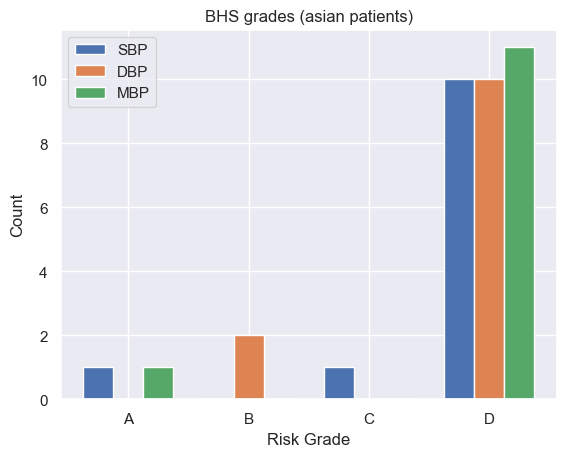

|     |   ≤5 mmHg |   ≤10 mmHg |   ≤15 mmHg | BHS Grade   |
|:----|----------:|-----------:|-----------:|:------------|
| SBP |   19.158  |    31.082  |    39.7857 | D           |
| DBP |   29.74   |    60.1164 |    80.7354 | D           |
| MBP |   25.1611 |    49.4788 |    72.0926 | D           |


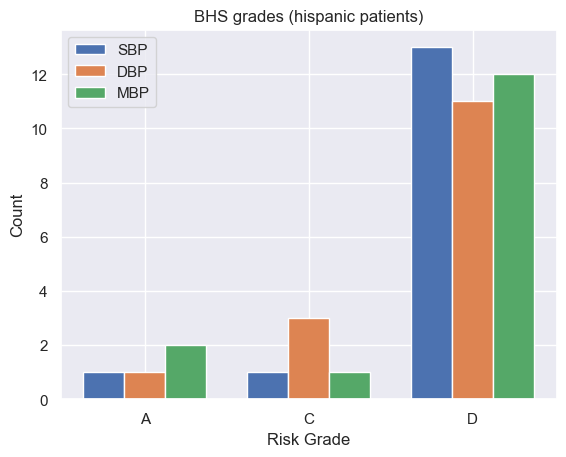

|     |   ≤5 mmHg |   ≤10 mmHg |   ≤15 mmHg | BHS Grade   |
|:----|----------:|-----------:|-----------:|:------------|
| SBP |   19.3119 |    34.2121 |    47.5452 | D           |
| DBP |   22.5155 |    39.2756 |    56.5634 | D           |
| MBP |   22.7788 |    42.6558 |    61.5539 | D           |


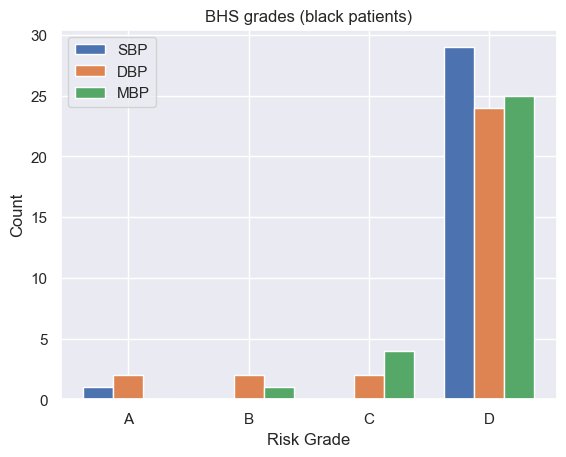

In [9]:
sbp_grades, dbp_grades, mbp_grades = vp.eval_patient_bulk(patient_race_sorted_dict['WHITE'][:10], episode_count=2)
vp.get_grades_plot(sbp_grades, dbp_grades, mbp_grades, "BHS grades (white patients)")

sbp_grades, dbp_grades, mbp_grades = vp.eval_patient_bulk(patient_race_sorted_dict['ASIAN'], episode_count=2)
vp.get_grades_plot(sbp_grades, dbp_grades, mbp_grades, "BHS grades (asian patients)")

sbp_grades, dbp_grades, mbp_grades = vp.eval_patient_bulk(patient_race_sorted_dict['HISPANIC'], episode_count=2)
vp.get_grades_plot(sbp_grades, dbp_grades, mbp_grades, "BHS grades (hispanic patients)")

sbp_grades, dbp_grades, mbp_grades = vp.eval_patient_bulk(patient_race_sorted_dict['BLACK'], episode_count=2)
vp.get_grades_plot(sbp_grades, dbp_grades, mbp_grades, "BHS grades (black patients)")

Across all the patients we have downloaded from MIMIC, the model performs horribly, recieving an Average grade of D for all demographic groups and from a statistical standpoint not performing significantly better or worse for any specific racial group with hispanics being the exception when predicting Diastolic Blood Pressure. However, we are working with significantly less hispanic patients compared to the other demographic groups.

With these results we can conclude that this model performs bad irregardless of race. However, as we observed before, the model does seem to do a good job at predicting the shape of the blood pressure signal; it just looks like it is offset. Next, we will explore calibrating these blood pressure predictions to see if the prediction results overall improve if we calibrate the predicted data using the first blood pressure episode.

### Blood pressure prediction calibration outcomes

Shown below are 11 episodes (1 minute) of data from the white patient we looked at before. As we can visually see in the graph. The offset observed above in the first 10 seconds of data persists across the whole minute worth of data while the shape of both lines remains relatively the same.

In [10]:
test_patient = patient_race_sorted_dict['WHITE'][selected_white_patient]
test_patient_records = hf.get_patient_records(test_patient)
test_patient_ppg, test_patient_real_bp, test_patient_ecg = hf.get_patient_episode_data(test_patient, 11)
test_patient_pred_bp = hf.predict_bp_from_ppg(test_patient_ppg)
test_patient_real_bp = hf.trim_waveform(test_patient_real_bp)

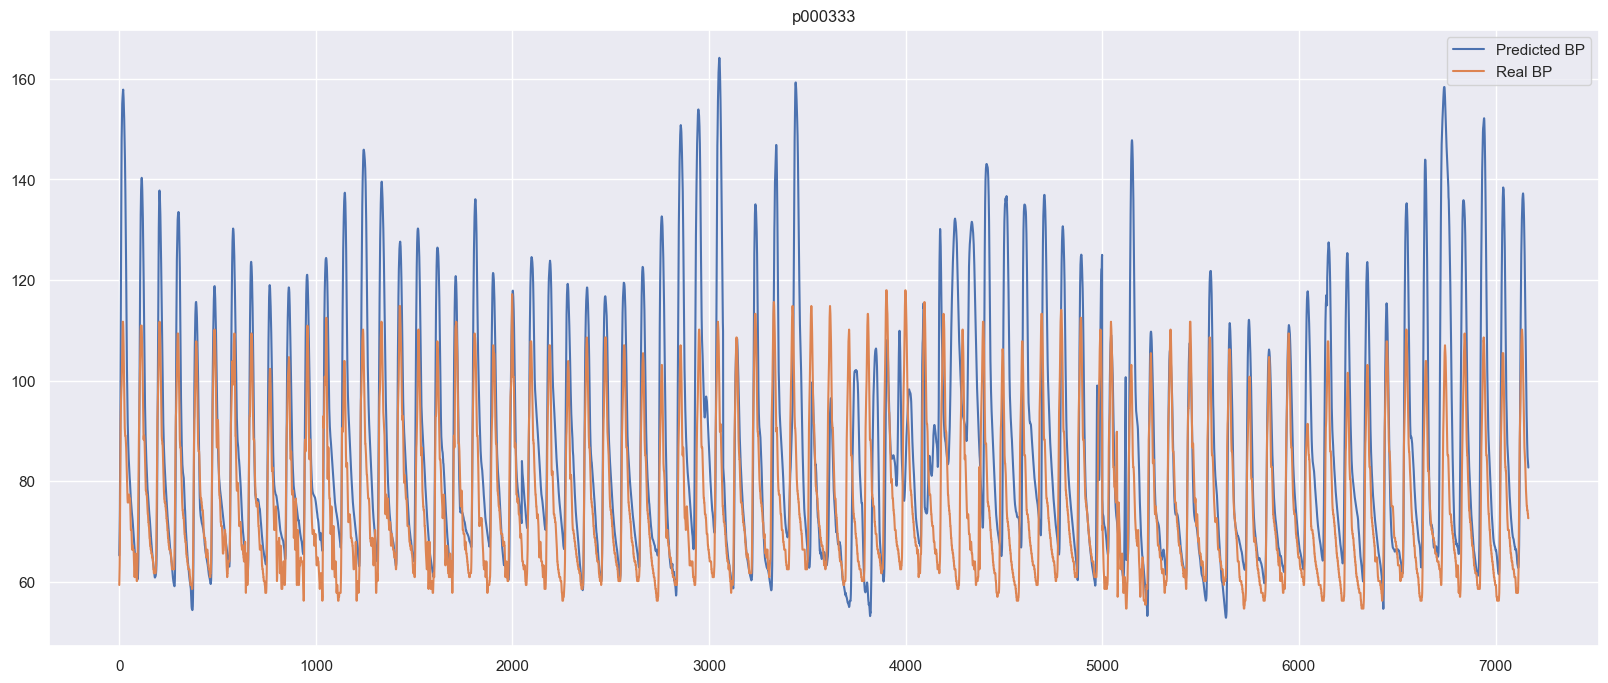

|     |   ≤5 mmHg |   ≤10 mmHg |   ≤15 mmHg | BHS Grade   |
|:----|----------:|-----------:|-----------:|:------------|
| SBP |   16.1765 |    26.4706 |    41.1765 | D           |
| DBP |   51.4706 |    89.7059 |    97.0588 | B           |
| MBP |   22.0588 |    54.4118 |    86.7647 | D           |


In [11]:
plt.figure(figsize=(20, 8))
plt.plot(test_patient_pred_bp, label="Predicted BP")
plt.plot(test_patient_real_bp, label="Real BP")
plt.title(test_patient)
plt.legend()
plt.show()

ef.eval_bhs_standard(test_patient_real_bp, test_patient_pred_bp, test_patient_ecg)

Now lets simulate a calibration step where we use the first bp episode from a given patients blood pressure data to determine how far off our predictions will be.

In [12]:
import calibration as cf

In [13]:
# get correction from a subset of the pred bp and actual bp readings
subset_length = 1024
a, b = cf.get_bp_correction(test_patient_pred_bp[:subset_length], test_patient_real_bp[:subset_length], test_patient_ecg)

In [14]:
# apply correction to whole predicted bp waveform
test_patient_pred_bp_corrected = cf.correct_bp(test_patient_pred_bp, a, b)

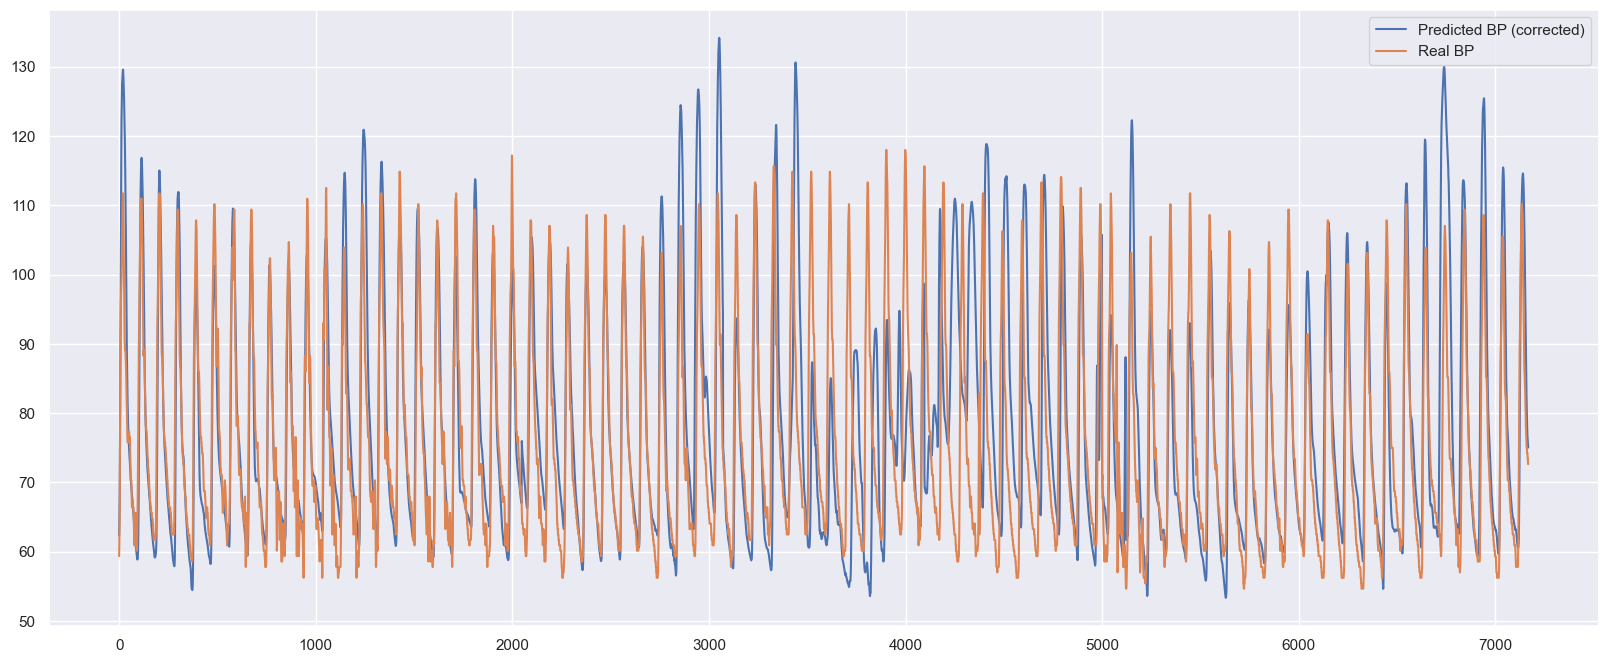

|     |   ≤5 mmHg |   ≤10 mmHg |   ≤15 mmHg | BHS Grade   |
|:----|----------:|-----------:|-----------:|:------------|
| SBP |   38.2353 |    63.2353 |    75      | D           |
| DBP |   75      |    97.0588 |   100      | A           |
| MBP |   76.4706 |    98.5294 |    98.5294 | A           |


In [15]:
# output results
plt.figure(figsize=(20, 8))
plt.plot(test_patient_pred_bp_corrected, label="Predicted BP (corrected)")
plt.plot(test_patient_real_bp, label="Real BP")
plt.legend()
plt.show()
ef.eval_bhs_standard(test_patient_real_bp, test_patient_pred_bp_corrected, test_patient_ecg)

As we can see, when we apply the correction algorithm the predicted BP results are significantly more accurate and meet the BHS standard requirements for clinical usage. Additionally, it is important to note that the only value we really care about is the MBP value because it is the only value we will be feeding into our CVE risk classification model. Therefore, we don't really care much for the SBP grade as long as the MBP grade is good. Now lets apply this correction across all of the patients we currently have for 2 episode segments (calibrating only using the first BP episode) to see how our BHS metrics hold up on average

|     |   ≤5 mmHg |   ≤10 mmHg |   ≤15 mmHg | BHS Grade   |
|:----|----------:|-----------:|-----------:|:------------|
| SBP |   37.8044 |    61.54   |    74.8399 | D           |
| DBP |   63.2982 |    91.4286 |    95.7143 | A           |
| MBP |   62.3891 |    81.7253 |    89.4832 | C           |


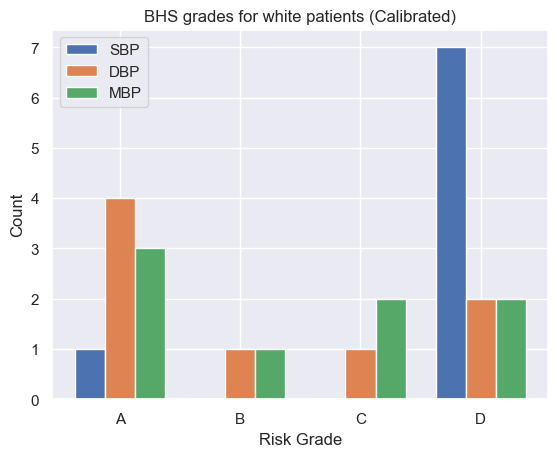

|     |   ≤5 mmHg |   ≤10 mmHg |   ≤15 mmHg | BHS Grade   |
|:----|----------:|-----------:|-----------:|:------------|
| SBP |   39.5205 |    61.7361 |    75.7176 | D           |
| DBP |   54.6759 |    80.9259 |    90.8333 | B           |
| MBP |   55.1521 |    78.9815 |    89.7222 | C           |


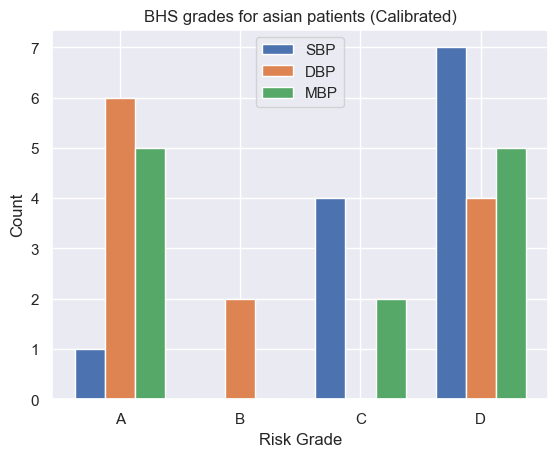

|     |   ≤5 mmHg |   ≤10 mmHg |   ≤15 mmHg | BHS Grade   |
|:----|----------:|-----------:|-----------:|:------------|
| SBP |   27.8728 |    51.7593 |    63.5714 | D           |
| DBP |   43.8889 |    66.1243 |    78.1217 | D           |
| MBP |   43.9153 |    69.336  |    82.6958 | D           |


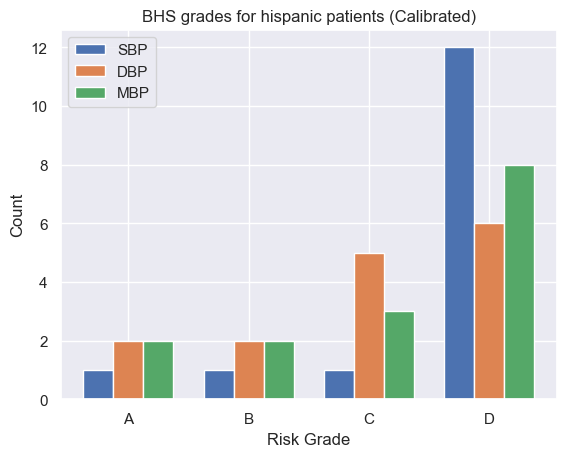

|     |   ≤5 mmHg |   ≤10 mmHg |   ≤15 mmHg | BHS Grade   |
|:----|----------:|-----------:|-----------:|:------------|
| SBP |   25.5264 |    46.0358 |    65.5227 | D           |
| DBP |   58.7822 |    80.4214 |    93.22   | B           |
| MBP |   52.9279 |    81.4299 |    93.0952 | B           |


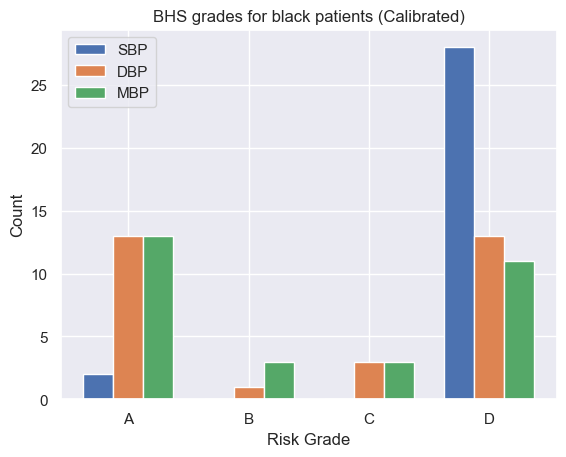

In [16]:
sbp_grades, dbp_grades, mbp_grades = vp.eval_patient_bulk(patient_race_sorted_dict['WHITE'][:10], episode_count=2, calibrated=True)
vp.get_grades_plot(sbp_grades, dbp_grades, mbp_grades, "BHS grades for white patients (Calibrated)")

sbp_grades, dbp_grades, mbp_grades = vp.eval_patient_bulk(patient_race_sorted_dict['ASIAN'], episode_count=2, calibrated=True)
vp.get_grades_plot(sbp_grades, dbp_grades, mbp_grades, "BHS grades for asian patients (Calibrated)")

sbp_grades, dbp_grades, mbp_grades = vp.eval_patient_bulk(patient_race_sorted_dict['HISPANIC'], episode_count=2, calibrated=True)
vp.get_grades_plot(sbp_grades, dbp_grades, mbp_grades, "BHS grades for hispanic patients (Calibrated)")

sbp_grades, dbp_grades, mbp_grades = vp.eval_patient_bulk(patient_race_sorted_dict['BLACK'], episode_count=2, calibrated=True)
vp.get_grades_plot(sbp_grades, dbp_grades, mbp_grades, "BHS grades for black patients (Calibrated)")

As we can see with calibration across all the patients in our database we are already getting significantly better predictions from our model. However, we still have a significant number of patients scoring within the D range across all demographic groups.

### Calculating whether a ppg waveform will give good or bad data

We will separate the examined patients into two groups. A group where the MBP grades are A and B (the good group) and a group where the MBP grades are C and D (the bad group)

In [17]:
white_bad, white_good = hf.get_good_bad_patient_split(patient_race_sorted_dict['WHITE'][:10], episode_count=2)
asian_bad, asian_good = hf.get_good_bad_patient_split(patient_race_sorted_dict['ASIAN'], episode_count=2)
hispanic_bad, hispanic_good = hf.get_good_bad_patient_split(patient_race_sorted_dict['HISPANIC'], episode_count=2)
black_bad, black_good = hf.get_good_bad_patient_split(patient_race_sorted_dict['BLACK'], episode_count=2)

Using the neurokit2 library we can get a ppg quality score for the data. This will help us see if there is something wrong with our model + calibration algorithm or if there is something wrong with the collected data.

In [18]:
import neurokit2 as nk

In [19]:
white_bad_ppg_mean, _, _, _, _, _, white_bad_ppg_grade_counts = ef.get_signal_quality_metrics(white_bad)
white_good_ppg_mean, _, _, _, _, _, white_good_ppg_grade_counts = ef.get_signal_quality_metrics(white_good)

print("---- White Good Patient Data Metrics ----")
print("Mean PPG Quality Score:", white_good_ppg_mean, '%')
print(white_good_ppg_grade_counts)

print("---- White Bad Patient Data Metrics ----")
print("Mean PPG Quality Score:", white_bad_ppg_mean, '%')
print(white_bad_ppg_grade_counts)
print()

asian_bad_ppg_mean, _, _, _, _, _, asian_bad_ppg_grade_counts = ef.get_signal_quality_metrics(asian_bad)
asian_good_ppg_mean, _, _, _, _, _, asian_good_ppg_grade_counts = ef.get_signal_quality_metrics(asian_good)

print("---- Asian Good Patient Data Metrics ----")
print("Mean PPG Quality Score:", asian_good_ppg_mean, '%')
print(asian_good_ppg_grade_counts)

print("---- Asian Bad Patient Data Metrics----")
print("Mean PPG Quality Score:", asian_bad_ppg_mean, '%')
print(asian_bad_ppg_grade_counts)
print()

hispanic_bad_ppg_mean, _, _, _, _, _, hispanic_bad_ppg_grade_counts = ef.get_signal_quality_metrics(hispanic_bad)
hispanic_good_ppg_mean, _, _, _, _, _, hispanic_good_ppg_grade_counts = ef.get_signal_quality_metrics(hispanic_good)

print("---- Hispanic Good Patient Data Metrics ----")
print("Mean PPG Quality Score:", hispanic_good_ppg_mean, '%')
print(hispanic_good_ppg_grade_counts)

print("---- Hispanic Bad Patient Data Metrics----")
print("Mean PPG Quality Score:", hispanic_bad_ppg_mean, '%')
print(hispanic_bad_ppg_grade_counts)
print()

black_bad_ppg_mean, _, _, _, _, _, black_bad_ppg_grade_counts = ef.get_signal_quality_metrics(black_bad)
black_good_ppg_mean, _, _, _, _, _, black_good_ppg_grade_counts = ef.get_signal_quality_metrics(black_good)

print("---- Black Good Patient Data Metrics ----")
print("Mean PPG Quality Score:", black_good_ppg_mean, '%')
print(black_good_ppg_grade_counts)

print("---- Black Bad Patient Data Metrics----")
print("Mean PPG Quality Score:", black_bad_ppg_mean, '%')
print(black_bad_ppg_grade_counts)
print()


---- White Good Patient Data Metrics ----
Mean PPG Quality Score: 95.98 %
{'A': 3, 'B': 1, 'C': 0, 'D': 0, 'F': 0}
---- White Bad Patient Data Metrics ----
Mean PPG Quality Score: 96.87 %
{'A': 4, 'B': 0, 'C': 0, 'D': 0, 'F': 0}

---- Asian Good Patient Data Metrics ----
Mean PPG Quality Score: 94.58 %
{'A': 4, 'B': 1, 'C': 0, 'D': 0, 'F': 0}
---- Asian Bad Patient Data Metrics----
Mean PPG Quality Score: 87.54 %
{'A': 4, 'B': 2, 'C': 0, 'D': 1, 'F': 0}

---- Hispanic Good Patient Data Metrics ----
Mean PPG Quality Score: 92.98 %
{'A': 3, 'B': 1, 'C': 0, 'D': 0, 'F': 0}
---- Hispanic Bad Patient Data Metrics----
Mean PPG Quality Score: 84.37 %
{'A': 4, 'B': 3, 'C': 4, 'D': 0, 'F': 0}

---- Black Good Patient Data Metrics ----
Mean PPG Quality Score: 91.53 %
{'A': 12, 'B': 1, 'C': 1, 'D': 1, 'F': 0}
---- Black Bad Patient Data Metrics----
Mean PPG Quality Score: 83.65 %
{'A': 7, 'B': 4, 'C': 2, 'D': 2, 'F': 0}



From this data we can see that patients who received good BHS scores when compared to the ground truth after calibration tend to have a higher PPG quality score showing that maybe if a patient has a ppg quality score less than 90%, the collected ppg data is not of high enough quality for the model to predict accurate results. Lets factor this metric into our pipeline and see how it affects our model's BHS grades.

|     |   ≤5 mmHg |   ≤10 mmHg |   ≤15 mmHg | BHS Grade   |
|:----|----------:|-----------:|-----------:|:------------|
| SBP |   37.8044 |    61.54   |    74.8399 | D           |
| DBP |   63.2982 |    91.4286 |    95.7143 | A           |
| MBP |   62.3891 |    81.7253 |    89.4832 | C           |


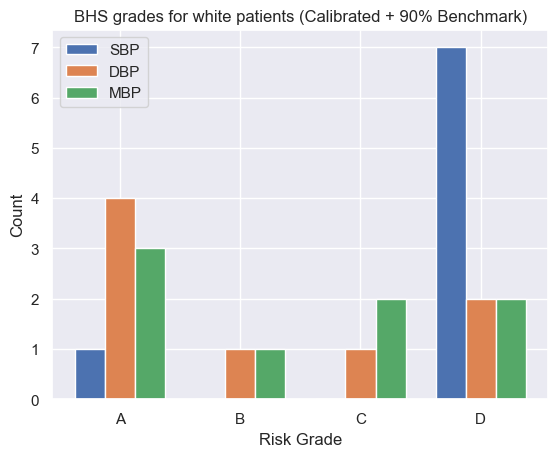

|     |   ≤5 mmHg |   ≤10 mmHg |   ≤15 mmHg | BHS Grade   |
|:----|----------:|-----------:|-----------:|:------------|
| SBP |   40.4718 |    65.1543 |    77.9938 | D           |
| DBP |   59.6914 |    86.2963 |    91.1111 | B           |
| MBP |   58.1041 |    80.2469 |    89.7531 | C           |


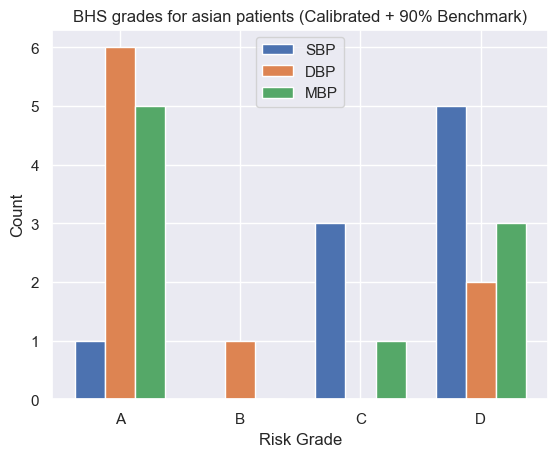

|     |   ≤5 mmHg |   ≤10 mmHg |   ≤15 mmHg | BHS Grade   |
|:----|----------:|-----------:|-----------:|:------------|
| SBP |   41.0534 |    66.5344 |    78.8801 | D           |
| DBP |   57.4295 |    81.746  |    93.5185 | B           |
| MBP |   57.0767 |    84.6781 |    96.2963 | B           |


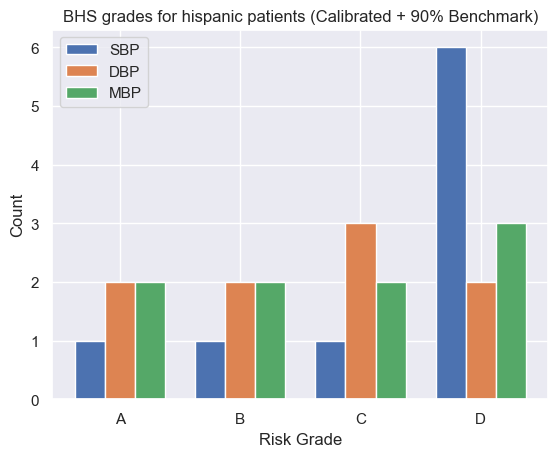

|     |   ≤5 mmHg |   ≤10 mmHg |   ≤15 mmHg | BHS Grade   |
|:----|----------:|-----------:|-----------:|:------------|
| SBP |   27.367  |    49.3692 |    69.3792 | D           |
| DBP |   67.3697 |    88.2393 |    97.5641 | A           |
| MBP |   61.4494 |    88.7519 |    95.4681 | A           |


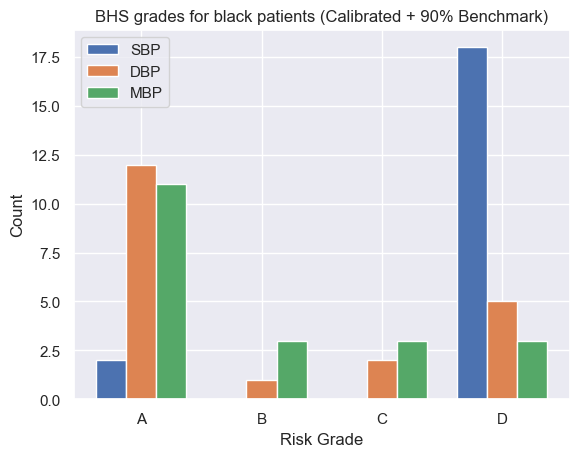

In [20]:
sbp_grades, dbp_grades, mbp_grades = vp.eval_patient_bulk(patient_race_sorted_dict['WHITE'][:10], episode_count=2, calibrated=True, filtered=True)
vp.get_grades_plot(sbp_grades, dbp_grades, mbp_grades, "BHS grades for white patients (Calibrated + 90% Benchmark)")

sbp_grades, dbp_grades, mbp_grades = vp.eval_patient_bulk(patient_race_sorted_dict['ASIAN'], episode_count=2, calibrated=True, filtered=True)
vp.get_grades_plot(sbp_grades, dbp_grades, mbp_grades, "BHS grades for asian patients (Calibrated + 90% Benchmark)")

sbp_grades, dbp_grades, mbp_grades = vp.eval_patient_bulk(patient_race_sorted_dict['HISPANIC'], episode_count=2, calibrated=True, filtered=True)
vp.get_grades_plot(sbp_grades, dbp_grades, mbp_grades, "BHS grades for hispanic patients (Calibrated + 90% Benchmark)")

sbp_grades, dbp_grades, mbp_grades = vp.eval_patient_bulk(patient_race_sorted_dict['BLACK'], episode_count=2, calibrated=True, filtered=True)
vp.get_grades_plot(sbp_grades, dbp_grades, mbp_grades, "BHS grades for black patients (Calibrated + 90% Benchmark)")

When the 90% benchmark is put in place, we can see that the model performs at a level on average where it is good enough to be used in clinical settings receiving mostly A and B grades (in the categories we care the most about for this project). This means that patients who receive a ppg quality score of 90% or greater and have their ppg predictions calibrated will most likely receive an accurate blood pressure prediction from PPG. However, it is important here to go back to our original concerns regarding model bias based on race and ask: is there a relationship between race and ppg quality?

In [21]:
white_ppg_mean, _, _, _, _, _, white_ppg_grade_counts = ef.get_signal_quality_metrics(patient_race_sorted_dict['WHITE'][:10])
asian_ppg_mean, _, _, _, _, _, asian_ppg_grade_counts = ef.get_signal_quality_metrics(patient_race_sorted_dict['ASIAN'])
hispanic_ppg_mean, _, _, _, _, _, hispanic_ppg_grade_counts = ef.get_signal_quality_metrics(patient_race_sorted_dict['HISPANIC'])
black_ppg_mean, _, _, _, _, _, black_ppg_grade_counts = ef.get_signal_quality_metrics(patient_race_sorted_dict['BLACK'])
print(f"White PPG Quality Mean: {white_ppg_mean:.2f}%")
print(f"Percentage of white patients that qualify: {(white_ppg_grade_counts['A']/sum(white_ppg_grade_counts.values())) * 100:.2f}%")
print()
print(f"Asian PPG Quality Mean: {asian_ppg_mean:.2f}%")
print(f"Percentage of asian patients that qualify: {(asian_ppg_grade_counts['A']/sum(asian_ppg_grade_counts.values())) * 100:.2f}%")
print()
print(f"Hispanic PPG Quality Mean: {hispanic_ppg_mean:.2f}%")
print(f"Percentage of hispanic patients that qualify: {(hispanic_ppg_grade_counts['A']/sum(hispanic_ppg_grade_counts.values())) * 100:.2f}%")
print()
print(f"Black PPG Quality Mean: {black_ppg_mean:.2f}%")
print(f"Percentage of black patients that qualify: {(black_ppg_grade_counts['A']/sum(black_ppg_grade_counts.values())) * 100:.2f}%")
print()

White PPG Quality Mean: 96.43%
Percentage of white patients that qualify: 87.50%

Asian PPG Quality Mean: 90.47%
Percentage of asian patients that qualify: 66.67%

Hispanic PPG Quality Mean: 86.67%
Percentage of hispanic patients that qualify: 46.67%

Black PPG Quality Mean: 87.59%
Percentage of black patients that qualify: 63.33%



From this data we can see that on average racial groups with darker skin tones receive lower ppg quality scores, however across all patients except hispanic patients (we only have 9 hispanic patients so I wouldn't really read those numbers as the word of god) we tend to see that around the same percentage of people from each demographic group has ppg scores that will qualify the metrics necessary to give good BP predictions. Overall with these findings we can reasonably conclude that there is **no** racial bias when predicting blood pressure from PPG.

Despite this fact, it is important to note that patients wont 100% of the time have good ppg readings so it is good practice to have something in place for when we get worse than optimal PPG readings so we can still have some context for what the actual BP reading is for a patient. This leads us into our final stage of this pipeline for getting good predictions using this model.

### Error Calculation
Using the data we can develop a system that is able to calculate the range for which values are off depending on their ppg quality score. This can be extremely helpful for all patients due to the fact that in real life situations, people move around when they sleep and this in turn can affect the quality of the ppg data collected by ppg devices. This will give us the ability not just say "due to a low quality ppg score this data may be inaccurate" but also be able to give the range of values that most likely will contain the accurate BP reading for episodes where the ppg quality is less than optimal.


In [22]:
import error as err

In [23]:
bins = err.get_patient_ppg_quality_bins(patient_list_complete, episode_count=2)
error_bounds = err.get_error_bounds_for_ppg_quality_metrics(bins, episode_count=2)

The above code creates a dictionary we can reference to get the 95% confidence error for a predicted blood pressure value based on the ppg quality score for a ppg episode. Using this dictionary we can get the error margins for our predicted values for when we know the predictions will be less than optimal. Because it is too much work for me to format the error bars for a single episode, we will be averaging the systolic diastolic and mean blood pressure values for am episode and applying the error margins to the episode averages rather than every peak for an episode to see if this improves our value predictions.

This format is the required format for what we will be feeding into our CVE risk assessment model due to the fact that instead of taking continuous BP data the model only takes data from every 30 seconds.

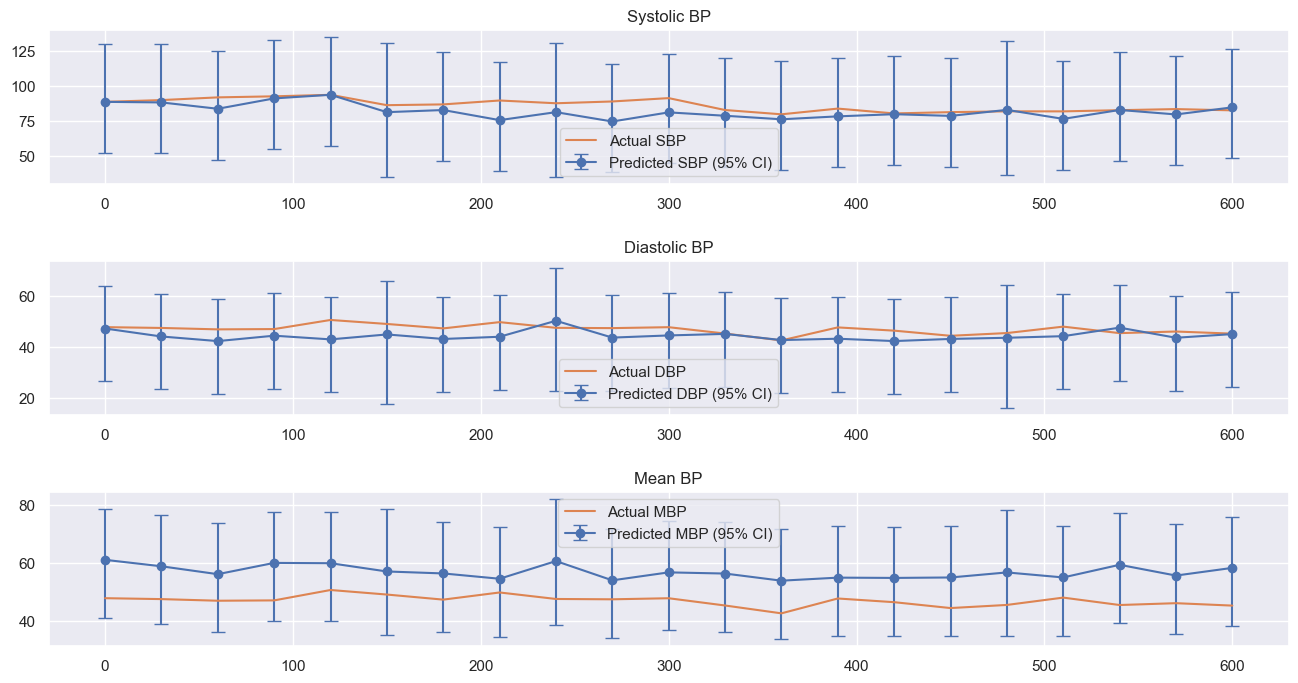

|     |   ≤5 mmHg |   ≤10 mmHg |   ≤15 mmHg | BHS Grade   |
|:----|----------:|-----------:|-----------:|:------------|
| SBP |   43.3453 |    73.3813 |    89.7482 | C           |
| DBP |   71.223  |    94.4245 |    96.9424 | A           |
| MBP |   71.223  |    94.2446 |    98.9209 | A           |
0.9633500014728145


In [49]:
test_patient = patient_race_sorted_dict['WHITE'][200]
test_patient_records = hf.get_patient_records(test_patient)

ppg, bp, ecg = hf.get_patient_episode_data(test_patient, 100)

pred_bp = hf.predict_bp_from_ppg(ppg)
bp = hf.trim_waveform(bp)
_, rr_ints, _, _ = cf.compute_heart_rate_from_ecg(ecg, fs=125)

subset_length = 1024
a, b = cf.get_bp_correction(pred_bp[:subset_length], bp[:subset_length], ecg)
pred_bp = cf.correct_bp(pred_bp, a, b)

timestamps = []
systolic_bp, systolic_bp_err, systolic_bp_actual = [], [], []
diastolic_bp, diastolic_bp_err, diastolic_bp_actual = [], [], []
mean_bp, mean_bp_err, mean_bp_actual = [], [], []


for i in range(0, len(ppg), subset_length * 3):
    # set episodes
    ppg_ep = ppg[i:i+subset_length]
    pred_bp_ep = pred_bp[i:i+subset_length]
    bp_ep = bp[i:i+subset_length]

    # calculate episode quality
    try:
        episode_quality_score = np.mean(nk.ppg_quality(ppg_ep, sampling_rate=125, method="templatematch")) * 100
    except Exception as e:
        continue

    # get error bounds for the calculated ppg quality
    quality_error = error_bounds[math.floor(episode_quality_score/10) * 10]

    # calculate the average systolic diastolic and mean blood pressure values for predictions and ground truths
    pred_sys_peaks, pred_dias_peaks = cf.get_peaks(pred_bp_ep, int(np.mean(rr_ints) * 125))
    actual_sys_peaks, actual_dias_peaks = cf.get_peaks(bp_ep, int(np.mean(rr_ints) * 125))

    pred_sys_peaks, actual_sys_peaks, pred_dias_peaks, actual_dias_peaks = (
        ef.truncate_to_match(pred_sys_peaks, actual_sys_peaks, pred_dias_peaks, actual_dias_peaks))

    pred_sys_peaks = pred_bp_ep[pred_sys_peaks]
    actual_sys_peaks = bp_ep[actual_sys_peaks]

    pred_dias_peaks = pred_bp_ep[pred_dias_peaks]
    actual_dias_peaks = bp_ep[actual_dias_peaks]

    actual_mbp = actual_dias_peaks + (actual_sys_peaks - actual_dias_peaks) / 3
    pred_mbp = pred_dias_peaks + (pred_sys_peaks - pred_dias_peaks) / 3

    avg_pred_sys = np.mean(pred_sys_peaks)
    avg_pred_dias = np.mean(pred_dias_peaks)
    avg_pred_mean = np.mean(pred_mbp)
    avg_actual_sys = np.mean(actual_sys_peaks)
    avg_actual_dias = np.mean(actual_dias_peaks)
    avg_actual_mean = np.mean(actual_mbp)

    # calculate errors
    sys_error = [abs(quality_error['sys errors'][0]), abs(quality_error['sys errors'][1])]
    dias_error = [abs(quality_error['dias errors'][0]), abs(quality_error['dias errors'][1])]
    mean_error = [abs(quality_error['mean errors'][0]), abs(quality_error['mean errors'][1])]

    # append the averages for the predictions and the ground truths to a running totals list
    timestamps.append((i/subset_length) * 10)
    systolic_bp.append(avg_pred_sys)
    systolic_bp_err.append(sys_error)
    systolic_bp_actual.append(avg_actual_sys)
    diastolic_bp.append(avg_pred_dias)
    diastolic_bp_err.append(dias_error)
    diastolic_bp_actual.append(avg_actual_dias)
    mean_bp.append(avg_pred_mean)
    mean_bp_err.append(mean_error)
    mean_bp_actual.append(avg_actual_dias)


# plot the predictions and the ground truths for really pretty visualization
fig, (sys, dias, mean) = plt.subplots(3, 1, figsize=(16, 8), gridspec_kw={'hspace': 0.5})
# systolic plot
sys.errorbar(timestamps, systolic_bp, yerr=np.array(systolic_bp_err).T, fmt='-o', capsize=5, label='Predicted SBP (95% CI)')
sys.plot(timestamps, systolic_bp_actual, label='Actual SBP')
sys.set_title("Systolic BP")
sys.legend()

# diastolic plot
dias.errorbar(timestamps, diastolic_bp, yerr=np.array(diastolic_bp_err).T, fmt='-o', capsize=5, label='Predicted DBP (95% CI)')
dias.plot(timestamps, diastolic_bp_actual, label='Actual DBP')
dias.set_title("Diastolic BP")
dias.legend()

# mean plot
mean.errorbar(timestamps, mean_bp, yerr=np.array(mean_bp_err).T, fmt='-o', capsize=5, label='Predicted MBP (95% CI)')
mean.plot(timestamps, mean_bp_actual, label='Actual MBP')
mean.set_title("Mean BP")
mean.legend()

plt.show()
ef.eval_bhs_standard(bp, pred_bp, ecg)
print(np.mean(nk.ppg_quality(ppg, sampling_rate=125, method="templatematch")))

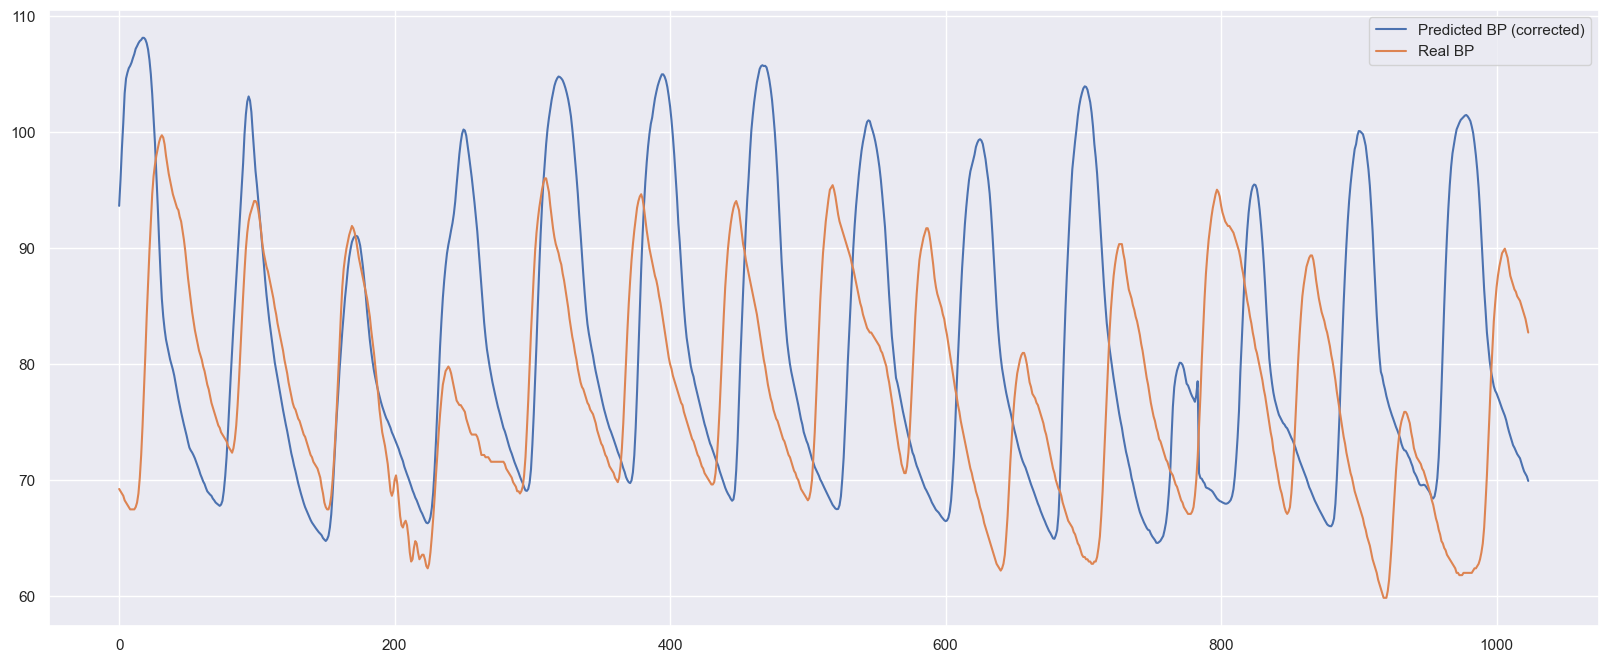

In [38]:
x = 9 * 1024

plt.figure(figsize=(20, 8))
plt.plot(pred_bp[x:x+subset_length], label="Predicted BP (corrected)")
plt.plot(bp[:subset_length], label="Real BP")
plt.legend()
plt.show()